In [1]:
import pandas as pd
import numpy as np
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
df = pd.read_csv("D:/repos/udemy/.dataset/winequality_red.csv", sep=';')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Normalizing the data
cols = df.columns.values.tolist()
cols.remove('quality')

In [5]:
df[cols] = df[cols].apply(stats.zscore)

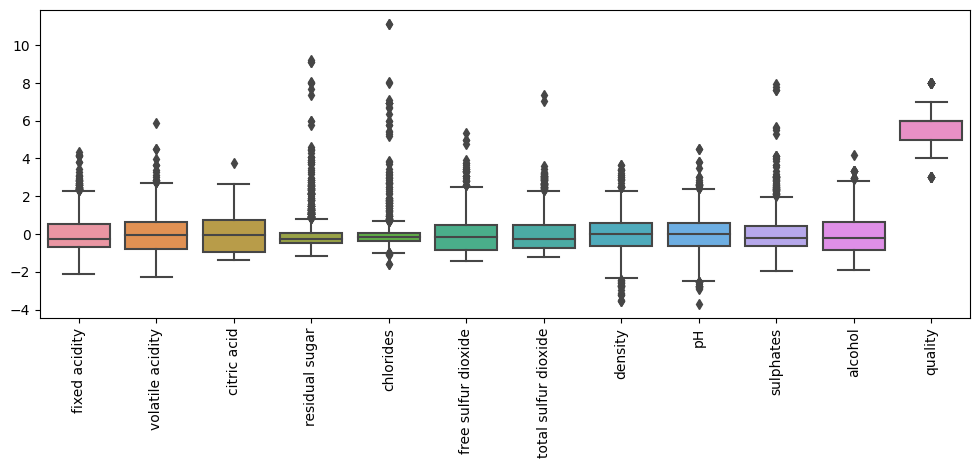

In [6]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

In [7]:
df['boolquality'] = np.where(df.quality>5, 1, 0)

In [8]:
tf_data = torch.tensor(df[cols].values).float()
tf_labels = torch.tensor(df.boolquality).float()
print(tf_data.shape)
print(tf_labels.shape)

torch.Size([1599, 11])
torch.Size([1599])


In [9]:
# We need to convert the labels to one dimensional tensor
tf_labels = tf_labels[:, None]
print(tf_labels.shape)

torch.Size([1599, 1])


In [10]:
x_train, x_test, y_train, y_test = train_test_split(tf_data, tf_labels, train_size=0.7)
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

batch = 64
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [11]:
test_data.tensors[0].shape[0]

480

In [12]:
for x, y in train_loader:
    print(x.shape, y.shape)

torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])


# Model

In [13]:
class model(nn.Module):
    def __init__(self, actfn):
        super().__init__()
        self.input = nn.Linear(11, 16)
        self.hidden1 = nn.Linear(16,32)
        self.hidden2 = nn.Linear(32,20)
        self.output = nn.Linear(20,1)
        self.actfn = actfn
    def forward(self, x):
        actfn = getattr(torch, self.actfn)
        x = actfn(self.input(x))
        x = actfn(self.hidden1(x))
        x = actfn(self.hidden2(x))
        x = self.output(x)
        return x

In [16]:
ann = model("sigmoid")
ann(torch.randn(10,11))

tensor([[-0.5007],
        [-0.5002],
        [-0.5019],
        [-0.5026],
        [-0.5019],
        [-0.4986],
        [-0.5007],
        [-0.5011],
        [-0.5006],
        [-0.5014]], grad_fn=<AddmmBackward0>)

In [19]:
ann(torch.randn(10,11)).shape

torch.Size([10, 1])

In [20]:
epochs = 1000
def train():
    # set the loss function and optimizer
    lossfn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ann.parameters(), lr=0.01)
    # initialize loss
    train_acc = []
    test_acc = []
    losses = []
    # triaining
    for i in range(epochs):
        ann.train()
        batchacc = []
        batchloss = []
        for xtrain, ytrain in train_loader:
            yhat = ann(xtrain)
            loss = lossfn(yhat, ytrain)
            batchloss.append(loss.detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # batch accuracy
            batchacc.append(100*torch.mean(((yhat>0) == ytrain).float()).item())
        # train accuracy
        train_acc.append(np.mean(batchacc))
        losses.append(np.mean(batchloss))
        # model evaluation
        ann.eval()
        xtest, ytest = next(iter(test_loader))
        with torch.no_grad():
            pred = ann(xtest)
        test_acc.append(100*torch.mean(((pred>0) == ytest).float()).item())

    return train_acc, test_acc, losses

In [21]:
activation_functions = ['sigmoid', 'relu', 'tanh']

In [22]:
train_acc_act = np.zeros((epochs, len(activation_functions)))
test_acc_act = np.zeros((epochs, len(activation_functions)))
losses_act = np.zeros((epochs, len(activation_functions)))

In [23]:
train_acc_act

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [26]:
for i, j in enumerate(activation_functions):
    ann = model(j)
    train_acc, test_acc, losses = train()
    train_acc_act[:,i] = train_acc
    test_acc_act[:,i] = test_acc
    losses_act[:,i] = losses

#### Sigmoid activation function is the worst choice for hidden units

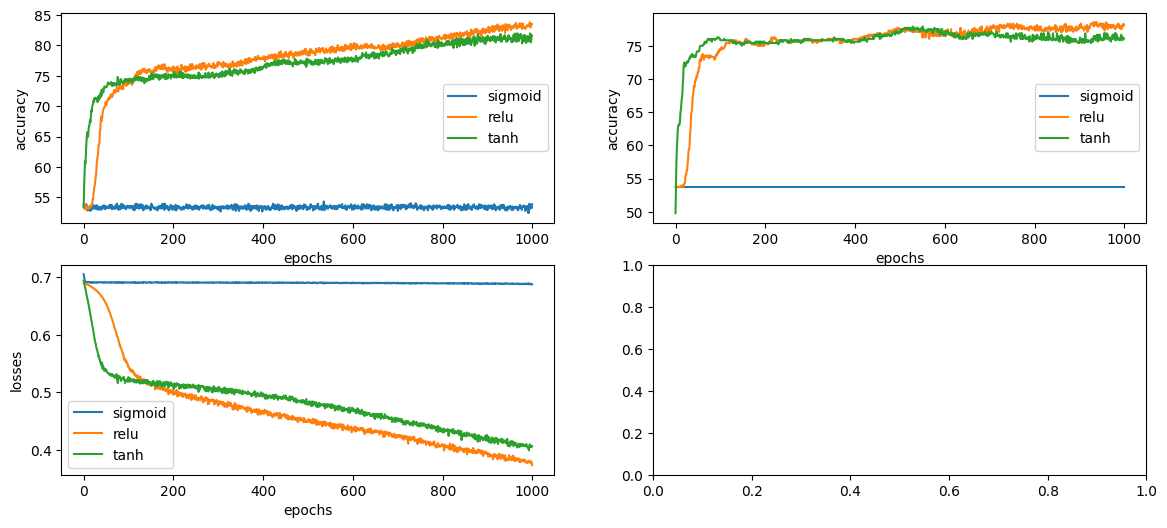

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(14,6))
ax[0,0].plot(range(epochs), train_acc_act)
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('accuracy')
ax[0,0].legend(activation_functions)

ax[0,1].plot(range(epochs), test_acc_act)
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('accuracy')
ax[0,1].legend(activation_functions)

ax[1,0].plot(range(epochs), losses_act)
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('losses')
ax[1,0].legend(activation_functions)

# Code challange

In [29]:
fn = getattr(torch, 'relu')
fn(torch.tensor(-1))

tensor(0)

In [32]:
fn = getattr(torch.nn, 'ReLU')
fn()(torch.tensor(-1))

tensor(0)

In [33]:
class model(nn.Module):
    def __init__(self, actfn):
        super().__init__()
        self.input = nn.Linear(11, 16)
        self.hidden1 = nn.Linear(16,32)
        self.hidden2 = nn.Linear(32,20)
        self.output = nn.Linear(20,1)
        self.actfn = actfn
    def forward(self, x):
        actfn = getattr(torch.nn, self.actfn)
        x = actfn()(self.input(x))
        x = actfn()(self.hidden1(x))
        x = actfn()(self.hidden2(x))
        x = self.output(x)
        return x

In [34]:
ann = model("ReLU")
ann(torch.randn(10,11))

tensor([[-0.2981],
        [-0.2956],
        [-0.2401],
        [-0.2576],
        [-0.2835],
        [-0.2277],
        [-0.3125],
        [-0.1750],
        [-0.3564],
        [-0.1860]], grad_fn=<AddmmBackward0>)

In [35]:
epochs = 1000
def train():
    # set the loss function and optimizer
    lossfn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ann.parameters(), lr=0.01)
    # initialize loss
    train_acc = []
    test_acc = []
    losses = []
    # triaining
    for i in range(epochs):
        ann.train()
        batchacc = []
        batchloss = []
        for xtrain, ytrain in train_loader:
            yhat = ann(xtrain)
            loss = lossfn(yhat, ytrain)
            batchloss.append(loss.detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # batch accuracy
            batchacc.append(100*torch.mean(((yhat>0) == ytrain).float()).item())
        # train accuracy
        train_acc.append(np.mean(batchacc))
        losses.append(np.mean(batchloss))
        # model evaluation
        ann.eval()
        xtest, ytest = next(iter(test_loader))
        with torch.no_grad():
            pred = ann(xtest)
        test_acc.append(100*torch.mean(((pred>0) == ytest).float()).item())

    return train_acc, test_acc, losses

In [37]:
activation_functions = ['ReLU', 'ReLU6', 'LeakyReLU']
train_acc_act = np.zeros((epochs, len(activation_functions)))
test_acc_act = np.zeros((epochs, len(activation_functions)))
losses_act = np.zeros((epochs, len(activation_functions)))

In [38]:
for i, j in enumerate(activation_functions):
    ann = model(j)
    train_acc, test_acc, losses = train()
    train_acc_act[:,i] = train_acc
    test_acc_act[:,i] = test_acc
    losses_act[:,i] = losses

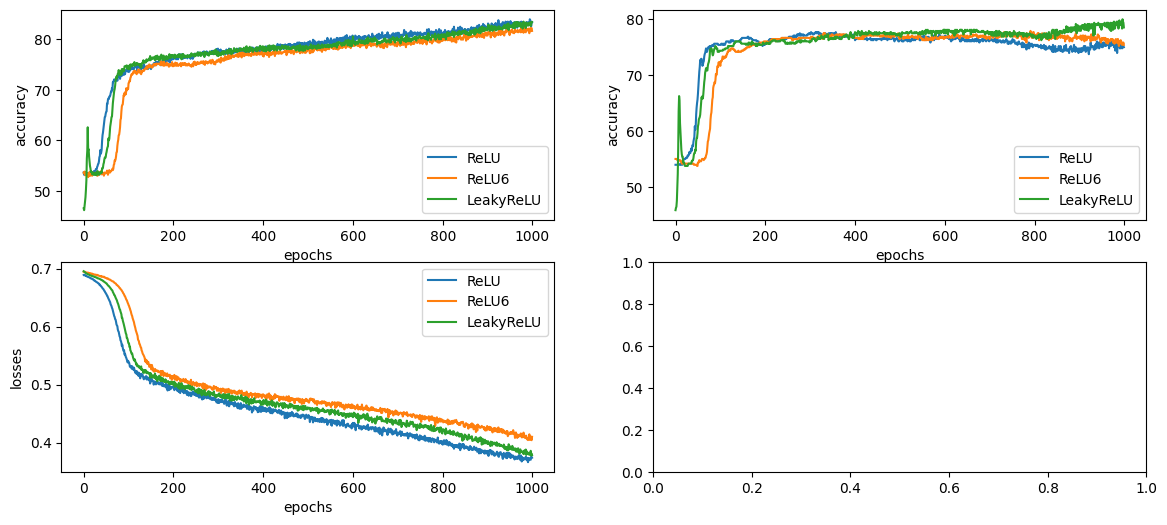

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(14,6))
ax[0,0].plot(range(epochs), train_acc_act)
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('accuracy')
ax[0,0].legend(activation_functions)

ax[0,1].plot(range(epochs), test_acc_act)
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('accuracy')
ax[0,1].legend(activation_functions)

ax[1,0].plot(range(epochs), losses_act)
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('losses')
ax[1,0].legend(activation_functions)